# Load Libraries

In [74]:
# numpy and pandas
import numpy as np
import pandas as pd
import math

# Generic
import os
import matplotlib.pyplot as plt

# Images
from PIL import Image
from skimage.transform import resize
import talos as ta

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, plot_confusion_matrix, roc_curve


# Tensorflow
import tensorflow as tf

# Keras
from keras.layers import Input, Dense, Dropout
from keras.utils import print_summary
from keras.models import Model, load_model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from keras.applications.densenet import DenseNet121
from keras.applications.densenet import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [30]:
import scikitplot as skplt
import matplotlib.pyplot as plt

In [67]:
y_true = y_train.reshape((y_train.shape[0],1))
y_probas = np.hstack((1-pred_train, pred_train))

In [68]:
y_probas.shape

(71, 2)

In [69]:
y_true.shape

(71, 1)

In [71]:
skplt.metrics.plot_roc_curve(y_true = y_true, y_probas = [1-pred_train, pred_train])
plt.show()

IndexError: index 1 is out of bounds for axis 1 with size 1

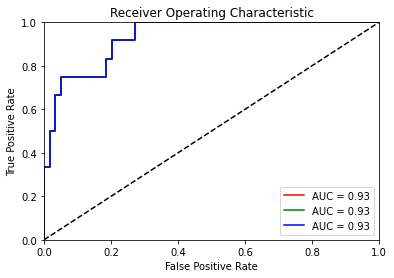

In [84]:
fpr_train, tpr_train, threshold_train = roc_curve(y_train, pred_train)
roc_auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
fpr_val, tpr_val, threshold_val = roc_curve(y_val, pred_val)
roc_auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
fpr_test, tpr_test, threshold_test = roc_curve(y_test, pred_test)
roc_auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr_train, tpr_train, 'r', label = 'AUC = %0.2f' % roc_auc_train)
plt.plot(fpr_val, tpr_val, 'g', label = 'AUC = %0.2f' % roc_auc_val)
plt.plot(fpr_test, tpr_test, 'b', label = 'AUC = %0.2f' % roc_auc_test)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'k--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
roc_auc_score(y_true = y_train, y_score = pred_train)

0.9322033898305085

# Load Classes and Functions

In [2]:
# chexNet weights
# https://github.com/brucechou1983/CheXNet-Keras
chexnet_weights = 'chexnet/best_weights.h5'

def chexnet_preprocess_input(value):
    return preprocess_input(value)


def get_chexnet_model():
    input_shape = (224, 224, 3)
    img_input = Input(shape=input_shape)
    base_weights = 'imagenet'

    # create the base pre-trained model
    base_model = DenseNet121(
        include_top=False,
        input_tensor=img_input,
        input_shape=input_shape,
        weights=base_weights,
        pooling='avg'
    )

    x = base_model.output
    # add a logistic layer -- let's say we have 14 classes
    predictions = Dense(
        14,
        activation='sigmoid',
        name='predictions')(x)

    # this is the model we will use
    model = Model(
        inputs=img_input,
        outputs=predictions,
    )

    # load chexnet weights
    model.load_weights(chexnet_weights)

    # return model
    return base_model, model

In [3]:
### funciones

def get_class_weight(csv_file_path, target_class):
    df = pd.read_csv(csv_file_path, sep=';')
    total_counts = df.shape[0]
    class_weight = []

    ratio_pos = df.loc[(df[target_class] == 'Y')].shape[0] / total_counts
    ratio_neg = df.loc[(df[target_class] == 'N')].shape[0] / total_counts
    class_weight = np.array((ratio_pos, ratio_neg))
        
    return class_weight

#def auc(y_true, y_pred):
#    auc = tf.metrics.auc(y_true, y_pred)[1]
#    K.get_session().run(tf.local_variables_initializer())
#    return auc

# define roc_callback, inspired by https://github.com/keras-team/keras/issues/6050#issuecomment-329996505
def auc(y_true, y_pred):
    # any tensorflow metric
    value, update_op = tf.metrics.auc(y_true, y_pred)

    # find all variables created for this metric
    metric_vars = [i for i in tf.local_variables() if 'auc' in i.name.split('/')[1]]

    # Add metric variables to GLOBAL_VARIABLES collection.
    # They will be initialized for new session.
    for v in metric_vars:
        tf.add_to_collection(tf.GraphKeys.GLOBAL_VARIABLES, v)

    # force to update metric values
    with tf.control_dependencies([update_op]):
        value = tf.identity(value)
    return value

#tf.keras.metrics.AUC(
#    num_thresholds=200, curve='ROC', summation_method='interpolation', name=None,
#    dtype=None, thresholds=None, multi_label=False, label_weights=None
#)

def get_model():
    # get base model, model
    base_model, chexnet_model = get_chexnet_model()
    # print a model summary
    # print_summary(base_model)

    x = base_model.output
    # Dropout layer
    x = Dropout(0.2)(x)
    # one more layer (relu)
    x = Dense(512, activation='relu')(x)
    # Dropout layer
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu')(x)
    # Dropout layer
    x = Dropout(0.2)(x)
    # add a logistic layer -- let's say we have 6 classes
    predictions = Dense(
        1,
        activation='sigmoid')(x)

    # this is the model we will use
    model = Model(
        inputs=base_model.input,
        outputs=predictions,
    )

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all base_model layers
    for layer in base_model.layers:
        layer.trainable = False

    # initiate an Adam optimizer
    opt = Adam(
        lr=learning_rate,
        beta_1=0.9,
        beta_2=0.999,
        decay=0.0,
        amsgrad=False
    )

    # Let's train the model using Adam
    model.compile(
        loss='binary_crossentropy',
        optimizer=opt,
        metrics=['accuracy', auc])

    return base_model, model



# Global Parameters

In [4]:
perc_split = [0.8, 0.2]
input_shape = (224, 224, 3)

### Hyperparameters
batch_size = 16
epochs = 10000
learning_rate = 0.0001


# Load Data

## Read data

In [5]:
case_features = pd.read_csv(os.path.join('../data/clean_data.csv'), sep=';');
new_case_features = pd.read_csv(os.path.join('../data/new_clean_data.csv'), sep=';');

## Split data

In [6]:
target_class = 'survival'
np.random.seed(23)

### Train and val
# Split patient ids
positive = case_features[case_features.survival.values == 'Y']
patient_ids = positive.patientid.unique()
train_ids = np.random.choice(patient_ids, size = math.floor(perc_split[0]*len(patient_ids)), replace = False)
test_ids = patient_ids[~np.isin(patient_ids, train_ids)];

negative = case_features[case_features.survival.values == 'N']
patient_ids = negative.patientid.unique()
train_ids = np.append(train_ids, np.random.choice(patient_ids, size = math.floor(perc_split[0]*len(patient_ids)), replace = False))
test_ids = np.append(test_ids, patient_ids[~np.isin(patient_ids, train_ids)]);

# Split dataset based on patient ids
case_features_train = case_features[case_features.patientid.isin(train_ids)]
case_features_val = case_features[case_features.patientid.isin(test_ids)]

# Selección del patrón de datos X y del target y
ytrain = case_features_train[target_class]
del case_features_train[target_class]
Xtrain = case_features_train

yval = case_features_val[target_class]
del case_features_val[target_class]
Xval = case_features_val


### Test
ytest = new_case_features[target_class]
del new_case_features[target_class]
Xtest = new_case_features

## Read images

### Train

In [7]:
X_train = []
for i in range(Xtrain.shape[0]):
    # print('%0.2f%%' % float(100*i/Xtrain.shape[0]))
    image_path = os.path.join('../data/', 'images', Xtrain.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_train.append(imagen)

X_train = np.stack(X_train, axis = 0)
print(X_train.shape)

(71, 224, 224, 3)


### Validation

In [8]:
X_val = []
for i in range(Xval.shape[0]):
    # print('%0.2f%%' % float(100*i/Xval.shape[0]))
    image_path = os.path.join('../data/', 'images', Xval.iloc[i].filename)
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_val.append(imagen)

X_val = np.stack(X_val, axis = 0)
print(X_val.shape)

(15, 224, 224, 3)


### Test

In [9]:
X_test = []
for i in range(Xtest.shape[0]):
    # print('%0.2f%%' % float(100*i/Xtest.shape[0]))
    image_path = os.path.join('../data/', 'new_images', Xtest.iloc[i].filename + '.jpeg')
    imagen = Image.open(image_path)
    imagen = np.asarray(imagen.convert("RGB"))
    imagen = resize(imagen,  input_shape)
    X_test.append(imagen)

X_test = np.stack(X_test, axis = 0)
print(X_test.shape)

(12, 224, 224, 3)


## Set target

### Train

In [10]:
ytrain[ytrain=='Y'] = 0
ytrain[ytrain=='N'] = 1
y_train = np.array(ytrain, dtype = np.int64)
y_train.shape

(71,)

### Validation

In [11]:
yval[yval=='Y'] = 0
yval[yval=='N'] = 1
y_val = np.array(yval, dtype = np.int64)
y_val.shape

(15,)

### Test

In [12]:
ytest[ytest=='Y'] = 0
ytest[ytest=='N'] = 1
y_test = np.array(ytest, dtype = np.int64)
y_test.shape

(12,)

## Set class weights

### Train

In [13]:
ratio_pos = np.count_nonzero(y_train == 0) / len(y_train)
ratio_neg = np.count_nonzero(y_train == 1) / len(y_train)
class_weight_train = np.array((ratio_pos, ratio_neg))
print(class_weight_train)


[0.83098592 0.16901408]


# Data Augmentation

In [14]:
datagen = ImageDataGenerator(featurewise_center=True, 
                             featurewise_std_normalization=True, 
                             rotation_range=90)
datagen.fit(X_train)

# Model Definition

## Callbacks

### Checkpoints

In [15]:
save_dir = os.path.join(
    os.getcwd(),
    '../saved_models'
)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)

# This callback saves the weights of the model after each epoch
checkpoint = ModelCheckpoint(
    '../saved_models/weights.epoch_{epoch:02d}.hdf5',
    monitor='val_loss', 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto',
    verbose=1
)

# This callback writes logs for TensorBoard
tensorboard = TensorBoard(
    log_dir='./Graph', 
    histogram_freq=0,  
    write_graph=True
)

# This callback writes logs for TensorBoard
tensorboard_augmented = TensorBoard(
    log_dir='./Graph_augmented', 
    histogram_freq=0,  
    write_graph=True
)


my_callbacks = EarlyStopping(monitor='val_auc', patience=100, verbose=1, mode='max')
my_callbacks_augmented = EarlyStopping(monitor='val_auc', patience=100, verbose=1, mode='max')

callbacks_list = [tensorboard, my_callbacks]
callbacks_list_augmented = [tensorboard_augmented, my_callbacks_augmented]

## Define CNN structure

In [16]:
# Fixed
base_model, model = get_model()

# Augmented
base_model_augmented, model_augmented = get_model()

# Show layers
#print_summary(model)
#print_summary(model2)



Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


# Model

## Original dataset

### Training

In [17]:
###### ENTRENAMIENTO
history = model.fit(X_train,y_train,
          validation_data=(X_val, y_val),
          batch_size=batch_size, 
          nb_epoch=epochs,
          class_weight=class_weight_train,
          callbacks = callbacks_list,
          verbose=1)




Train on 71 samples, validate on 15 samples


Epoch 1/10000
71/71 [==============================] - 17s 236ms/step - loss: 0.7054 - accuracy: 0.5211 - auc: 0.3649 - val_loss: 0.3526 - val_accuracy: 0.9333 - val_auc: 0.4520

Epoch 2/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.4347 - accuracy: 0.8310 - auc: 0.5184 - val_loss: 0.2459 - val_accuracy: 0.9333 - val_auc: 0.5424
Epoch 3/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.4528 - accuracy: 0.8310 - auc: 0.5499 - val_loss: 0.2362 - val_accuracy: 0.9333 - val_auc: 0.5637
Epoch 4/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.4685 - accuracy: 0.8310 - auc: 0.5768 - val_loss: 0.2383 - val_accuracy: 0.9333 - val_auc: 0.5969
Epoch 5/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.4420 - accuracy: 0.8310 - auc: 0.6213 - val_loss: 0.2491 - val_accuracy: 0.9333 - val_auc: 0.6356
Epoch 6/10000
71/71 [==============================] - 6s 89ms/step 

71/71 [==============================] - 6s 90ms/step - loss: 0.2365 - accuracy: 0.9014 - auc: 0.8849 - val_loss: 0.2857 - val_accuracy: 0.9333 - val_auc: 0.8850
Epoch 87/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.2176 - accuracy: 0.9437 - auc: 0.8853 - val_loss: 0.3192 - val_accuracy: 0.8000 - val_auc: 0.8859
Epoch 88/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.2401 - accuracy: 0.9155 - auc: 0.8861 - val_loss: 0.3328 - val_accuracy: 0.8000 - val_auc: 0.8866
Epoch 89/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.2304 - accuracy: 0.9155 - auc: 0.8868 - val_loss: 0.3064 - val_accuracy: 0.8667 - val_auc: 0.8872
Epoch 90/10000
71/71 [==============================] - 7s 92ms/step - loss: 0.2399 - accuracy: 0.9155 - auc: 0.8872 - val_loss: 0.3062 - val_accuracy: 0.8000 - val_auc: 0.8878
Epoch 91/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.2163 - accuracy: 0.9155 - auc: 0.8878 - val_loss: 0

71/71 [==============================] - 7s 92ms/step - loss: 0.1758 - accuracy: 0.9296 - auc: 0.9142 - val_loss: 0.3170 - val_accuracy: 0.8000 - val_auc: 0.9143
Epoch 179/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.1827 - accuracy: 0.9437 - auc: 0.9144 - val_loss: 0.3095 - val_accuracy: 0.8000 - val_auc: 0.9146
Epoch 180/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.1751 - accuracy: 0.9437 - auc: 0.9146 - val_loss: 0.2990 - val_accuracy: 0.8000 - val_auc: 0.9148
Epoch 181/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.1938 - accuracy: 0.9155 - auc: 0.9149 - val_loss: 0.3165 - val_accuracy: 0.8000 - val_auc: 0.9150
Epoch 182/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.1715 - accuracy: 0.9437 - auc: 0.9151 - val_loss: 0.3793 - val_accuracy: 0.7333 - val_auc: 0.9153
Epoch 183/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.1767 - accuracy: 0.9155 - auc: 0.9153 - val_lo

71/71 [==============================] - 6s 89ms/step - loss: 0.1470 - accuracy: 0.9437 - auc: 0.9283 - val_loss: 0.3856 - val_accuracy: 0.7333 - val_auc: 0.9284
Epoch 271/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.1510 - accuracy: 0.9296 - auc: 0.9285 - val_loss: 0.4078 - val_accuracy: 0.7333 - val_auc: 0.9286
Epoch 272/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.1606 - accuracy: 0.9296 - auc: 0.9286 - val_loss: 0.3597 - val_accuracy: 0.7333 - val_auc: 0.9287
Epoch 273/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.1473 - accuracy: 0.9437 - auc: 0.9287 - val_loss: 0.3489 - val_accuracy: 0.7333 - val_auc: 0.9288
Epoch 274/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.1375 - accuracy: 0.9437 - auc: 0.9288 - val_loss: 0.3508 - val_accuracy: 0.7333 - val_auc: 0.9290
Epoch 275/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.1343 - accuracy: 0.9718 - auc: 0.9290 - val_lo

71/71 [==============================] - 6s 88ms/step - loss: 0.1373 - accuracy: 0.9577 - auc: 0.9381 - val_loss: 0.4430 - val_accuracy: 0.7333 - val_auc: 0.9382
Epoch 363/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.2150 - accuracy: 0.9437 - auc: 0.9381 - val_loss: 0.3902 - val_accuracy: 0.7333 - val_auc: 0.9381
Epoch 364/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.1583 - accuracy: 0.9577 - auc: 0.9381 - val_loss: 0.3775 - val_accuracy: 0.7333 - val_auc: 0.9381
Epoch 365/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.1033 - accuracy: 0.9859 - auc: 0.9382 - val_loss: 0.3685 - val_accuracy: 0.7333 - val_auc: 0.9383
Epoch 366/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.1098 - accuracy: 0.9718 - auc: 0.9383 - val_loss: 0.3620 - val_accuracy: 0.7333 - val_auc: 0.9384
Epoch 367/10000
71/71 [==============================] - 7s 92ms/step - loss: 0.0903 - accuracy: 0.9718 - auc: 0.9385 - val_lo

71/71 [==============================] - 6s 90ms/step - loss: 0.1376 - accuracy: 0.9437 - auc: 0.9447 - val_loss: 0.4055 - val_accuracy: 0.7333 - val_auc: 0.9447
Epoch 455/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0923 - accuracy: 0.9859 - auc: 0.9447 - val_loss: 0.3940 - val_accuracy: 0.7333 - val_auc: 0.9448
Epoch 456/10000
71/71 [==============================] - 6s 92ms/step - loss: 0.1073 - accuracy: 0.9437 - auc: 0.9448 - val_loss: 0.4116 - val_accuracy: 0.7333 - val_auc: 0.9449
Epoch 457/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0958 - accuracy: 0.9718 - auc: 0.9449 - val_loss: 0.3992 - val_accuracy: 0.7333 - val_auc: 0.9450
Epoch 458/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.1459 - accuracy: 0.9577 - auc: 0.9450 - val_loss: 0.3947 - val_accuracy: 0.7333 - val_auc: 0.9449
Epoch 459/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.1100 - accuracy: 0.9577 - auc: 0.9449 - val_lo

71/71 [==============================] - 6s 88ms/step - loss: 0.0768 - accuracy: 1.0000 - auc: 0.9490 - val_loss: 0.4731 - val_accuracy: 0.7333 - val_auc: 0.9491
Epoch 547/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.1146 - accuracy: 0.9577 - auc: 0.9490 - val_loss: 0.4704 - val_accuracy: 0.7333 - val_auc: 0.9491
Epoch 548/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.1119 - accuracy: 0.9718 - auc: 0.9491 - val_loss: 0.4414 - val_accuracy: 0.7333 - val_auc: 0.9491
Epoch 549/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.1078 - accuracy: 0.9718 - auc: 0.9491 - val_loss: 0.4383 - val_accuracy: 0.7333 - val_auc: 0.9491
Epoch 550/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0988 - accuracy: 0.9718 - auc: 0.9491 - val_loss: 0.4955 - val_accuracy: 0.7333 - val_auc: 0.9492
Epoch 551/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0734 - accuracy: 0.9718 - auc: 0.9492 - val_lo

71/71 [==============================] - 6s 90ms/step - loss: 0.1098 - accuracy: 0.9718 - auc: 0.9524 - val_loss: 0.5788 - val_accuracy: 0.7333 - val_auc: 0.9525
Epoch 639/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.1027 - accuracy: 0.9859 - auc: 0.9524 - val_loss: 0.5256 - val_accuracy: 0.7333 - val_auc: 0.9525
Epoch 640/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0755 - accuracy: 0.9859 - auc: 0.9525 - val_loss: 0.5239 - val_accuracy: 0.7333 - val_auc: 0.9525
Epoch 641/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0817 - accuracy: 0.9859 - auc: 0.9525 - val_loss: 0.5022 - val_accuracy: 0.7333 - val_auc: 0.9526
Epoch 642/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0803 - accuracy: 0.9859 - auc: 0.9525 - val_loss: 0.5159 - val_accuracy: 0.7333 - val_auc: 0.9526
Epoch 643/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0844 - accuracy: 0.9718 - auc: 0.9526 - val_lo

71/71 [==============================] - 6s 89ms/step - loss: 0.0548 - accuracy: 0.9859 - auc: 0.9549 - val_loss: 0.5466 - val_accuracy: 0.7333 - val_auc: 0.9549
Epoch 731/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0924 - accuracy: 0.9577 - auc: 0.9549 - val_loss: 0.5872 - val_accuracy: 0.7333 - val_auc: 0.9549
Epoch 732/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0504 - accuracy: 1.0000 - auc: 0.9549 - val_loss: 0.5499 - val_accuracy: 0.7333 - val_auc: 0.9550
Epoch 733/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.1086 - accuracy: 0.9859 - auc: 0.9549 - val_loss: 0.5506 - val_accuracy: 0.7333 - val_auc: 0.9550
Epoch 734/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0692 - accuracy: 0.9718 - auc: 0.9549 - val_loss: 0.5799 - val_accuracy: 0.7333 - val_auc: 0.9550
Epoch 735/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0617 - accuracy: 0.9859 - auc: 0.9550 - val_lo

71/71 [==============================] - 6s 89ms/step - loss: 0.0632 - accuracy: 0.9718 - auc: 0.9567 - val_loss: 0.5917 - val_accuracy: 0.7333 - val_auc: 0.9567
Epoch 823/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0516 - accuracy: 1.0000 - auc: 0.9567 - val_loss: 0.6466 - val_accuracy: 0.7333 - val_auc: 0.9567
Epoch 824/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0489 - accuracy: 1.0000 - auc: 0.9567 - val_loss: 0.6883 - val_accuracy: 0.7333 - val_auc: 0.9567
Epoch 825/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0705 - accuracy: 0.9718 - auc: 0.9567 - val_loss: 0.6553 - val_accuracy: 0.7333 - val_auc: 0.9568
Epoch 826/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0688 - accuracy: 0.9859 - auc: 0.9567 - val_loss: 0.6431 - val_accuracy: 0.7333 - val_auc: 0.9568
Epoch 827/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0826 - accuracy: 0.9859 - auc: 0.9567 - val_lo

71/71 [==============================] - 6s 90ms/step - loss: 0.0577 - accuracy: 0.9859 - auc: 0.9581 - val_loss: 0.6751 - val_accuracy: 0.7333 - val_auc: 0.9581
Epoch 915/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0524 - accuracy: 0.9859 - auc: 0.9581 - val_loss: 0.7671 - val_accuracy: 0.7333 - val_auc: 0.9581
Epoch 916/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0520 - accuracy: 1.0000 - auc: 0.9581 - val_loss: 0.7334 - val_accuracy: 0.7333 - val_auc: 0.9582
Epoch 917/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0635 - accuracy: 0.9718 - auc: 0.9581 - val_loss: 0.6761 - val_accuracy: 0.7333 - val_auc: 0.9582
Epoch 918/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0401 - accuracy: 1.0000 - auc: 0.9582 - val_loss: 0.6441 - val_accuracy: 0.7333 - val_auc: 0.9582
Epoch 919/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0538 - accuracy: 0.9859 - auc: 0.9582 - val_lo

71/71 [==============================] - 6s 90ms/step - loss: 0.0565 - accuracy: 0.9859 - auc: 0.9589 - val_loss: 0.9224 - val_accuracy: 0.7333 - val_auc: 0.9589
Epoch 1009/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0569 - accuracy: 1.0000 - auc: 0.9589 - val_loss: 0.9072 - val_accuracy: 0.7333 - val_auc: 0.9589
Epoch 1010/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0439 - accuracy: 1.0000 - auc: 0.9589 - val_loss: 0.7852 - val_accuracy: 0.7333 - val_auc: 0.9589
Epoch 1011/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0409 - accuracy: 1.0000 - auc: 0.9589 - val_loss: 0.6671 - val_accuracy: 0.7333 - val_auc: 0.9589
Epoch 1012/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0391 - accuracy: 1.0000 - auc: 0.9589 - val_loss: 0.6969 - val_accuracy: 0.7333 - val_auc: 0.9589
Epoch 1013/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0806 - accuracy: 0.9718 - auc: 0.9589 - v

Epoch 1054/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0460 - accuracy: 0.9859 - auc: 0.9593 - val_loss: 0.6956 - val_accuracy: 0.7333 - val_auc: 0.9593
Epoch 1055/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0595 - accuracy: 0.9859 - auc: 0.9593 - val_loss: 0.7720 - val_accuracy: 0.7333 - val_auc: 0.9593
Epoch 1056/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0319 - accuracy: 1.0000 - auc: 0.9593 - val_loss: 0.7926 - val_accuracy: 0.7333 - val_auc: 0.9594
Epoch 1057/10000
71/71 [==============================] - 6s 86ms/step - loss: 0.0925 - accuracy: 0.9718 - auc: 0.9593 - val_loss: 0.7598 - val_accuracy: 0.7333 - val_auc: 0.9594
Epoch 1058/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0382 - accuracy: 0.9859 - auc: 0.9593 - val_loss: 0.6698 - val_accuracy: 0.7333 - val_auc: 0.9594
Epoch 1059/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0503 - accuracy: 0.9718 

Epoch 1100/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0419 - accuracy: 0.9859 - auc: 0.9596 - val_loss: 0.7856 - val_accuracy: 0.7333 - val_auc: 0.9597
Epoch 1101/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0518 - accuracy: 0.9859 - auc: 0.9596 - val_loss: 0.8463 - val_accuracy: 0.7333 - val_auc: 0.9597
Epoch 1102/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0368 - accuracy: 0.9859 - auc: 0.9596 - val_loss: 0.8166 - val_accuracy: 0.7333 - val_auc: 0.9597
Epoch 1103/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0325 - accuracy: 1.0000 - auc: 0.9596 - val_loss: 0.7476 - val_accuracy: 0.7333 - val_auc: 0.9597
Epoch 1104/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0270 - accuracy: 1.0000 - auc: 0.9597 - val_loss: 0.6975 - val_accuracy: 0.7333 - val_auc: 0.9597
Epoch 1105/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0332 - accuracy: 1.0000 

Epoch 1146/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0453 - accuracy: 1.0000 - auc: 0.9599 - val_loss: 0.7756 - val_accuracy: 0.7333 - val_auc: 0.9600
Epoch 1147/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0606 - accuracy: 0.9718 - auc: 0.9599 - val_loss: 0.8333 - val_accuracy: 0.7333 - val_auc: 0.9600
Epoch 1148/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0337 - accuracy: 0.9859 - auc: 0.9599 - val_loss: 0.7539 - val_accuracy: 0.7333 - val_auc: 0.9600
Epoch 1149/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0417 - accuracy: 0.9859 - auc: 0.9600 - val_loss: 0.7363 - val_accuracy: 0.7333 - val_auc: 0.9600
Epoch 1150/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0669 - accuracy: 0.9718 - auc: 0.9600 - val_loss: 0.7919 - val_accuracy: 0.7333 - val_auc: 0.9600
Epoch 1151/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0446 - accuracy: 0.9859 

Epoch 1192/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0347 - accuracy: 1.0000 - auc: 0.9602 - val_loss: 0.7649 - val_accuracy: 0.7333 - val_auc: 0.9602
Epoch 1193/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0213 - accuracy: 1.0000 - auc: 0.9602 - val_loss: 0.7030 - val_accuracy: 0.7333 - val_auc: 0.9602
Epoch 1194/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0408 - accuracy: 0.9859 - auc: 0.9602 - val_loss: 0.6979 - val_accuracy: 0.7333 - val_auc: 0.9602
Epoch 1195/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0274 - accuracy: 1.0000 - auc: 0.9602 - val_loss: 0.7850 - val_accuracy: 0.7333 - val_auc: 0.9602
Epoch 1196/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0600 - accuracy: 0.9859 - auc: 0.9602 - val_loss: 0.8020 - val_accuracy: 0.7333 - val_auc: 0.9602
Epoch 1197/10000
71/71 [==============================] - 6s 86ms/step - loss: 0.0378 - accuracy: 1.0000 

Epoch 1238/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0757 - accuracy: 0.9718 - auc: 0.9604 - val_loss: 0.9856 - val_accuracy: 0.7333 - val_auc: 0.9605
Epoch 1239/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0449 - accuracy: 1.0000 - auc: 0.9604 - val_loss: 0.9924 - val_accuracy: 0.7333 - val_auc: 0.9605
Epoch 1240/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0359 - accuracy: 1.0000 - auc: 0.9605 - val_loss: 0.8053 - val_accuracy: 0.7333 - val_auc: 0.9605
Epoch 1241/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0239 - accuracy: 1.0000 - auc: 0.9605 - val_loss: 0.7014 - val_accuracy: 0.7333 - val_auc: 0.9605
Epoch 1242/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0676 - accuracy: 0.9718 - auc: 0.9605 - val_loss: 0.7012 - val_accuracy: 0.7333 - val_auc: 0.9605
Epoch 1243/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0239 - accuracy: 1.0000 

Epoch 1284/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0614 - accuracy: 0.9859 - auc: 0.9605 - val_loss: 0.7060 - val_accuracy: 0.7333 - val_auc: 0.9605
Epoch 1285/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0712 - accuracy: 0.9718 - auc: 0.9605 - val_loss: 0.6792 - val_accuracy: 0.7333 - val_auc: 0.9605
Epoch 1286/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0453 - accuracy: 1.0000 - auc: 0.9605 - val_loss: 0.7554 - val_accuracy: 0.7333 - val_auc: 0.9605
Epoch 1287/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0322 - accuracy: 1.0000 - auc: 0.9605 - val_loss: 0.8049 - val_accuracy: 0.7333 - val_auc: 0.9605
Epoch 1288/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0398 - accuracy: 1.0000 - auc: 0.9605 - val_loss: 0.8248 - val_accuracy: 0.7333 - val_auc: 0.9606
Epoch 1289/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0267 - accuracy: 1.0000 

Epoch 1330/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0236 - accuracy: 1.0000 - auc: 0.9608 - val_loss: 0.8347 - val_accuracy: 0.7333 - val_auc: 0.9608
Epoch 1331/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0217 - accuracy: 1.0000 - auc: 0.9608 - val_loss: 0.8343 - val_accuracy: 0.7333 - val_auc: 0.9608
Epoch 1332/10000
71/71 [==============================] - 7s 92ms/step - loss: 0.0330 - accuracy: 0.9859 - auc: 0.9608 - val_loss: 0.8569 - val_accuracy: 0.7333 - val_auc: 0.9608
Epoch 1333/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0205 - accuracy: 1.0000 - auc: 0.9608 - val_loss: 0.8381 - val_accuracy: 0.7333 - val_auc: 0.9608
Epoch 1334/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0486 - accuracy: 0.9859 - auc: 0.9608 - val_loss: 0.8618 - val_accuracy: 0.7333 - val_auc: 0.9608
Epoch 1335/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0344 - accuracy: 0.9859 

Epoch 1376/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0308 - accuracy: 1.0000 - auc: 0.9609 - val_loss: 0.7573 - val_accuracy: 0.7333 - val_auc: 0.9610
Epoch 1377/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0891 - accuracy: 0.9577 - auc: 0.9609 - val_loss: 0.9329 - val_accuracy: 0.7333 - val_auc: 0.9609
Epoch 1378/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0486 - accuracy: 1.0000 - auc: 0.9609 - val_loss: 0.9818 - val_accuracy: 0.7333 - val_auc: 0.9609
Epoch 1379/10000
71/71 [==============================] - 7s 92ms/step - loss: 0.0257 - accuracy: 1.0000 - auc: 0.9609 - val_loss: 0.8358 - val_accuracy: 0.7333 - val_auc: 0.9610
Epoch 1380/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0142 - accuracy: 1.0000 - auc: 0.9609 - val_loss: 0.7998 - val_accuracy: 0.7333 - val_auc: 0.9610
Epoch 1381/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0434 - accuracy: 0.9859 

Epoch 1422/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0192 - accuracy: 1.0000 - auc: 0.9611 - val_loss: 0.8388 - val_accuracy: 0.7333 - val_auc: 0.9612
Epoch 1423/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0194 - accuracy: 1.0000 - auc: 0.9611 - val_loss: 0.8707 - val_accuracy: 0.7333 - val_auc: 0.9612
Epoch 1424/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0175 - accuracy: 1.0000 - auc: 0.9611 - val_loss: 0.8965 - val_accuracy: 0.7333 - val_auc: 0.9612
Epoch 1425/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0229 - accuracy: 1.0000 - auc: 0.9612 - val_loss: 0.8917 - val_accuracy: 0.7333 - val_auc: 0.9612
Epoch 1426/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0387 - accuracy: 0.9859 - auc: 0.9612 - val_loss: 0.9477 - val_accuracy: 0.7333 - val_auc: 0.9612
Epoch 1427/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0240 - accuracy: 1.0000 

Epoch 1468/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0421 - accuracy: 0.9859 - auc: 0.9613 - val_loss: 0.8120 - val_accuracy: 0.7333 - val_auc: 0.9613
Epoch 1469/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0319 - accuracy: 1.0000 - auc: 0.9613 - val_loss: 1.0217 - val_accuracy: 0.7333 - val_auc: 0.9613
Epoch 1470/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0340 - accuracy: 1.0000 - auc: 0.9613 - val_loss: 1.0392 - val_accuracy: 0.7333 - val_auc: 0.9613
Epoch 1471/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0333 - accuracy: 1.0000 - auc: 0.9613 - val_loss: 0.9927 - val_accuracy: 0.7333 - val_auc: 0.9613
Epoch 1472/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0174 - accuracy: 1.0000 - auc: 0.9613 - val_loss: 0.9315 - val_accuracy: 0.7333 - val_auc: 0.9613
Epoch 1473/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0610 - accuracy: 0.9859 

Epoch 1514/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0260 - accuracy: 1.0000 - auc: 0.9614 - val_loss: 1.0635 - val_accuracy: 0.7333 - val_auc: 0.9615
Epoch 1515/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0276 - accuracy: 1.0000 - auc: 0.9614 - val_loss: 0.9331 - val_accuracy: 0.7333 - val_auc: 0.9615
Epoch 1516/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0205 - accuracy: 1.0000 - auc: 0.9615 - val_loss: 0.8426 - val_accuracy: 0.7333 - val_auc: 0.9615
Epoch 1517/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0173 - accuracy: 1.0000 - auc: 0.9615 - val_loss: 0.8363 - val_accuracy: 0.7333 - val_auc: 0.9615
Epoch 1518/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0144 - accuracy: 1.0000 - auc: 0.9615 - val_loss: 0.8385 - val_accuracy: 0.7333 - val_auc: 0.9615
Epoch 1519/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0633 - accuracy: 0.9718 

Epoch 1560/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0978 - accuracy: 0.9718 - auc: 0.9616 - val_loss: 1.4278 - val_accuracy: 0.6667 - val_auc: 0.9616
Epoch 1561/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0680 - accuracy: 0.9859 - auc: 0.9616 - val_loss: 1.0197 - val_accuracy: 0.7333 - val_auc: 0.9616
Epoch 1562/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0165 - accuracy: 1.0000 - auc: 0.9616 - val_loss: 0.7520 - val_accuracy: 0.7333 - val_auc: 0.9616
Epoch 1563/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0329 - accuracy: 0.9859 - auc: 0.9616 - val_loss: 0.7035 - val_accuracy: 0.7333 - val_auc: 0.9616
Epoch 1564/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0452 - accuracy: 0.9718 - auc: 0.9616 - val_loss: 0.7850 - val_accuracy: 0.7333 - val_auc: 0.9616
Epoch 1565/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0322 - accuracy: 0.9859 

Epoch 1606/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0316 - accuracy: 0.9859 - auc: 0.9617 - val_loss: 0.9912 - val_accuracy: 0.7333 - val_auc: 0.9617
Epoch 1607/10000
71/71 [==============================] - 7s 92ms/step - loss: 0.0155 - accuracy: 1.0000 - auc: 0.9617 - val_loss: 0.9272 - val_accuracy: 0.7333 - val_auc: 0.9617
Epoch 1608/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0385 - accuracy: 0.9859 - auc: 0.9617 - val_loss: 0.9774 - val_accuracy: 0.7333 - val_auc: 0.9617
Epoch 1609/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0220 - accuracy: 1.0000 - auc: 0.9617 - val_loss: 0.9805 - val_accuracy: 0.7333 - val_auc: 0.9617
Epoch 1610/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0432 - accuracy: 0.9859 - auc: 0.9617 - val_loss: 0.9700 - val_accuracy: 0.7333 - val_auc: 0.9617
Epoch 1611/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0363 - accuracy: 0.9859 

Epoch 1652/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0121 - accuracy: 1.0000 - auc: 0.9619 - val_loss: 0.9152 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1653/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0193 - accuracy: 1.0000 - auc: 0.9619 - val_loss: 0.9758 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1654/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0130 - accuracy: 1.0000 - auc: 0.9619 - val_loss: 1.0000 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1655/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0123 - accuracy: 1.0000 - auc: 0.9619 - val_loss: 0.9811 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1656/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0157 - accuracy: 1.0000 - auc: 0.9619 - val_loss: 0.9499 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1657/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0148 - accuracy: 1.0000 

Epoch 1698/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0213 - accuracy: 0.9859 - auc: 0.9619 - val_loss: 0.8829 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1699/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0197 - accuracy: 1.0000 - auc: 0.9619 - val_loss: 0.9188 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1700/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0141 - accuracy: 1.0000 - auc: 0.9619 - val_loss: 1.0147 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1701/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0249 - accuracy: 1.0000 - auc: 0.9619 - val_loss: 1.0417 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1702/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0360 - accuracy: 1.0000 - auc: 0.9619 - val_loss: 1.0796 - val_accuracy: 0.7333 - val_auc: 0.9619
Epoch 1703/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0168 - accuracy: 1.0000 

Epoch 1744/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.1188 - accuracy: 0.9718 - auc: 0.9620 - val_loss: 0.9511 - val_accuracy: 0.7333 - val_auc: 0.9620
Epoch 1745/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0268 - accuracy: 1.0000 - auc: 0.9620 - val_loss: 1.2917 - val_accuracy: 0.6667 - val_auc: 0.9620
Epoch 1746/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0377 - accuracy: 1.0000 - auc: 0.9620 - val_loss: 1.1367 - val_accuracy: 0.7333 - val_auc: 0.9620
Epoch 1747/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0163 - accuracy: 1.0000 - auc: 0.9620 - val_loss: 0.9389 - val_accuracy: 0.7333 - val_auc: 0.9620
Epoch 1748/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0358 - accuracy: 0.9718 - auc: 0.9620 - val_loss: 0.8646 - val_accuracy: 0.7333 - val_auc: 0.9620
Epoch 1749/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0276 - accuracy: 1.0000 

Epoch 1790/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0146 - accuracy: 1.0000 - auc: 0.9621 - val_loss: 0.9638 - val_accuracy: 0.7333 - val_auc: 0.9621
Epoch 1791/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0149 - accuracy: 1.0000 - auc: 0.9621 - val_loss: 0.9722 - val_accuracy: 0.7333 - val_auc: 0.9621
Epoch 1792/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0221 - accuracy: 0.9859 - auc: 0.9621 - val_loss: 1.0425 - val_accuracy: 0.7333 - val_auc: 0.9621
Epoch 1793/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0153 - accuracy: 1.0000 - auc: 0.9621 - val_loss: 1.1175 - val_accuracy: 0.7333 - val_auc: 0.9621
Epoch 1794/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0294 - accuracy: 1.0000 - auc: 0.9621 - val_loss: 1.1208 - val_accuracy: 0.7333 - val_auc: 0.9621
Epoch 1795/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0357 - accuracy: 0.9859 

Epoch 1836/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0226 - accuracy: 1.0000 - auc: 0.9621 - val_loss: 1.0983 - val_accuracy: 0.7333 - val_auc: 0.9621
Epoch 1837/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0184 - accuracy: 1.0000 - auc: 0.9621 - val_loss: 1.1023 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1838/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0159 - accuracy: 1.0000 - auc: 0.9621 - val_loss: 1.0541 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1839/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0124 - accuracy: 1.0000 - auc: 0.9621 - val_loss: 0.9883 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1840/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0427 - accuracy: 0.9859 - auc: 0.9621 - val_loss: 1.0029 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1841/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0282 - accuracy: 1.0000 

Epoch 1882/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0318 - accuracy: 0.9859 - auc: 0.9622 - val_loss: 1.0416 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1883/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0232 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 0.9519 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1884/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0206 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 0.9696 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1885/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0117 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 1.0195 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1886/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0062 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 1.0716 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1887/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0177 - accuracy: 1.0000 

Epoch 1928/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0156 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 0.8709 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1929/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0278 - accuracy: 0.9859 - auc: 0.9622 - val_loss: 0.9116 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1930/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0289 - accuracy: 0.9859 - auc: 0.9622 - val_loss: 1.0632 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1931/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0170 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 1.2676 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1932/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0350 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 1.3084 - val_accuracy: 0.6667 - val_auc: 0.9622
Epoch 1933/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0186 - accuracy: 1.0000 

Epoch 1974/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0366 - accuracy: 0.9859 - auc: 0.9622 - val_loss: 0.9924 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 1975/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0365 - accuracy: 0.9859 - auc: 0.9622 - val_loss: 1.1026 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 1976/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0238 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 1.3238 - val_accuracy: 0.6667 - val_auc: 0.9622
Epoch 1977/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0461 - accuracy: 0.9718 - auc: 0.9622 - val_loss: 1.1505 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 1978/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0302 - accuracy: 0.9859 - auc: 0.9622 - val_loss: 0.9455 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 1979/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0193 - accuracy: 1.0000 

Epoch 2020/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0293 - accuracy: 0.9859 - auc: 0.9623 - val_loss: 1.1448 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2021/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0105 - accuracy: 1.0000 - auc: 0.9623 - val_loss: 1.0794 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2022/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0118 - accuracy: 1.0000 - auc: 0.9623 - val_loss: 1.0441 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2023/10000
71/71 [==============================] - 6s 88ms/step - loss: 0.0102 - accuracy: 1.0000 - auc: 0.9623 - val_loss: 1.0532 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2024/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0132 - accuracy: 1.0000 - auc: 0.9623 - val_loss: 1.0517 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2025/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0098 - accuracy: 1.0000 

Epoch 2066/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0096 - accuracy: 1.0000 - auc: 0.9623 - val_loss: 1.0512 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2067/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0121 - accuracy: 1.0000 - auc: 0.9623 - val_loss: 1.1053 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2068/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0112 - accuracy: 1.0000 - auc: 0.9623 - val_loss: 1.1194 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2069/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0340 - accuracy: 0.9859 - auc: 0.9623 - val_loss: 1.1357 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2070/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0140 - accuracy: 1.0000 - auc: 0.9623 - val_loss: 1.1131 - val_accuracy: 0.7333 - val_auc: 0.9623
Epoch 2071/10000
71/71 [==============================] - 6s 87ms/step - loss: 0.0656 - accuracy: 0.9859 

Epoch 2112/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0078 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 1.3693 - val_accuracy: 0.6667 - val_auc: 0.9622
Epoch 2113/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0352 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 1.3458 - val_accuracy: 0.6667 - val_auc: 0.9622
Epoch 2114/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0144 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 1.1222 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 2115/10000
71/71 [==============================] - 6s 91ms/step - loss: 0.0288 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 0.9590 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 2116/10000
71/71 [==============================] - 6s 89ms/step - loss: 0.0165 - accuracy: 1.0000 - auc: 0.9622 - val_loss: 0.9717 - val_accuracy: 0.7333 - val_auc: 0.9622
Epoch 2117/10000
71/71 [==============================] - 6s 90ms/step - loss: 0.0090 - accuracy: 1.0000 

In [18]:
save_dir = os.path.join(
    os.getcwd(),
    '../model_results'
)
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model.save('../model_results/model.h5')  

### Predict

In [19]:
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_test = model.predict(X_test)

### Metrics

In [20]:
auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)
print('AUC train = %s - AUC val = %s - AUC test = %s' % (str(auc_train), str(auc_val), str(auc_test)))

AUC train = 0.9322033898305085 - AUC val = 0.5714285714285714 - AUC test = 0.8571428571428571


In [21]:
y_labels_train = (pred_train >= 0.5).astype(int)
y_labels_val = (pred_val >= 0.5).astype(int)
y_labels_test = (pred_test >= 0.5).astype(int)
cm_train = confusion_matrix(y_pred = y_labels_train, y_true = y_train)
cm_val = confusion_matrix(y_pred = y_labels_val, y_true = y_val)
cm_test = confusion_matrix(y_pred = y_labels_test, y_true = y_test)
print(cm_train)
print(cm_val)
print(cm_test)

[[43 16]
 [ 0 12]]
[[11  3]
 [ 1  0]]
[[4 1]
 [3 4]]


### Save output

In [22]:
X_train.to_csv(os.path.join('../predictions', 'X_train.csv'))
np.savetxt(os.path.join('../predictions', 'predictions_train.csv'), pred_train, delimiter=";")
np.savetxt(os.path.join('../predictions', 'y_train.csv'), y_train, delimiter=";")
X_val.to_csv(os.path.join('../predictions', 'X_val.csv'))
np.savetxt(os.path.join('../predictions', 'predictions_val.csv'), pred_val, delimiter=";")
np.savetxt(os.path.join('../predictions', 'y_val.csv'), y_val, delimiter=";")
X_test.to_csv(os.path.join('../predictions', 'X_test.csv'))
np.savetxt(os.path.join('../predictions', 'predictions_test.csv'),pred_test, delimiter=";")
np.savetxt(os.path.join('../predictions', 'y_test.csv'), y_test, delimiter=";")

AttributeError: 'numpy.ndarray' object has no attribute 'to_csv'

## Augmented dataset

### Training

In [ ]:
###### ENTRENAMIENTO
model_augmented.fit_generator(datagen.flow(X_train, y_train, batch_size=batch_size),
                     validation_data=datagen.flow(X_val, y_val),
                     steps_per_epoch=len(X_train) / batch_size, 
                     epochs=epochs,
                     class_weight=class_weight_train,
                     callbacks = callbacks_list_augmented,       
                     verbose=1)

In [ ]:
model_augmented.save('../model_results/model_augmented.h5')  

### Predict

In [ ]:
pred_train = model_augmented.predict(X_train)
pred_val = model_augmented.predict(X_val)
pred_test = model_augmented.predict(X_test)

### Metrics

In [ ]:
auc_train = roc_auc_score(y_true = y_train, y_score = pred_train)
auc_val = roc_auc_score(y_true = y_val, y_score = pred_val)
auc_test = roc_auc_score(y_true = y_test, y_score = pred_test)
print('AUC train = %s - AUC val = %s - AUC test = %s' % (str(auc_train), str(auc_val), str(auc_test)))

In [ ]:
y_labels_train = (pred_train >= 0.5).astype(int)
y_labels_val = (pred_val >= 0.5).astype(int)
y_labels_test = (pred_test >= 0.5).astype(int)
cm_train = confusion_matrix(y_pred = y_labels_train, y_true = y_train)
cm_val = confusion_matrix(y_pred = y_labels_val, y_true = y_val)
cm_test = confusion_matrix(y_pred = y_labels_test, y_true = y_test)
print(cm_train)
print(cm_val)
print(cm_test)

### Save output

In [ ]:
Xtrain.to_csv(os.path.join('../predictions', 'X_train_augmented.csv'))
np.savetxt(os.path.join('../predictions', 'predictions_train_augmented.csv'), pred_train, delimiter=";")
np.savetxt(os.path.join('../predictions', 'y_train_augmented.csv'), y_train, delimiter=";")
Xval.to_csv(os.path.join('../predictions', 'X_val_augmented.csv'))
np.savetxt(os.path.join('../predictions', 'predictions_val_augmented.csv'), pred_val, delimiter=";")
np.savetxt(os.path.join('../predictions', 'y_val_augmented.csv'), y_val, delimiter=";")
Xtest.to_csv(os.path.join('../predictions', 'X_test_augmented.csv'))
np.savetxt(os.path.join('../predictions', 'predictions_test_augmented.csv'),pred_test, delimiter=";")
np.savetxt(os.path.join('../predictions', 'y_test_augmented.csv'), y_test, delimiter=";")